In [4]:
import rasterio as rio
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import mean_squared_error
import seaborn as sns
from functools import reduce
import cv2

In [7]:
def scaled(x):
    min_val, max_val = np.percentile(x, (2, 98))

    # Scale the pixel values to the range of 0-255
    return np.interp(x, (min_val, max_val), (0, 255)).astype(np.uint8)

def sigmoid(x):
    return 255 / (1 + np.exp(-4 * (scaled(x) / 255 - 0.5)))

def get_tci(img):
    r = sigmoid(img.read(4))
    g = sigmoid(img.read(3))
    b = sigmoid(img.read(2))
    rgb = np.stack([r, g, b])
    rgb = (rgb.transpose(1, 2, 0)).astype(np.uint8)
    return rgb

path = Path('../../imgs')
images = {p.name: p  for p in path.iterdir()}
path_imgs = [im for im in images['s2'].iterdir()]
rio_cloudless = [get_tci(rio.open(path)) for path in path_imgs]
path_imgs = [im for im in images['s2_cloudy'].iterdir()]
rio_cloudies = [get_tci(rio.open(path)) for path in path_imgs]

In [21]:
def compute_saturation(image):
    # Convert the image from RGB to HSV color space
    img_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    # Extract the saturation channel
    sat = img_hsv[:, :, 1]

    return sat.mean()

def compute_color_temperature(image):
    # Convert the image from RGB to CIE 1931 XYZ color space
    img_xyz = cv2.cvtColor(image, cv2.COLOR_RGB2XYZ)

    # Calculate the chromaticity coordinates
    sum_xyz = np.sum(img_xyz, axis=(0, 1))
    x = sum_xyz[0] / np.sum(sum_xyz)
    y = sum_xyz[1] / np.sum(sum_xyz)

    # Calculate the correlated color temperature (CCT)
    n = (x - 0.332) / (0.1858 - y)
    cct = 449 * (n ** 3) + 3525 * (n ** 2) + 6823.3 * n + 5520.33

    return cct

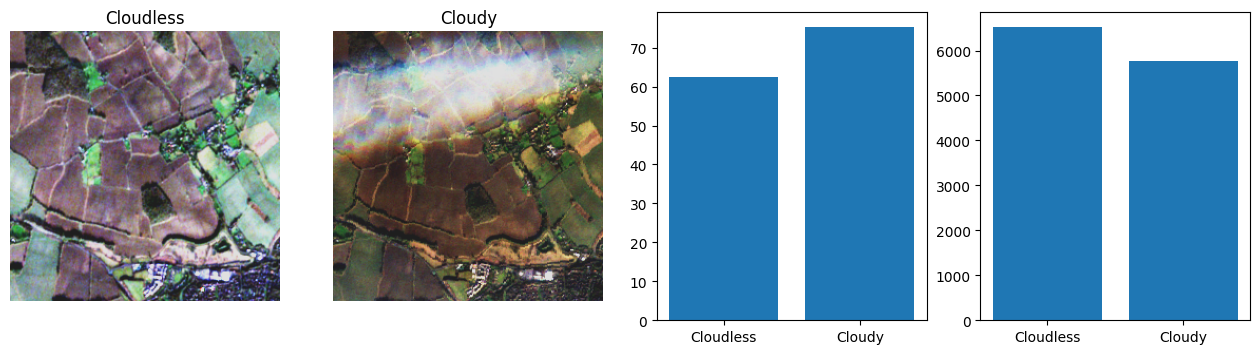

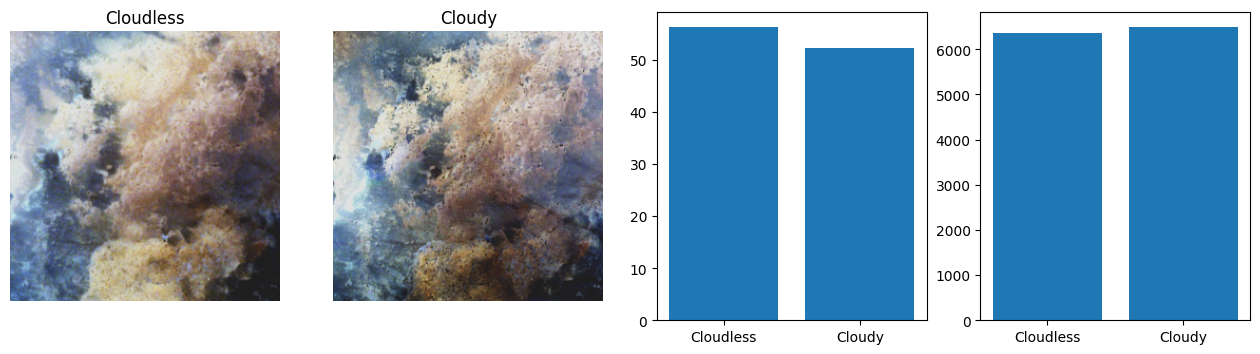

In [22]:
def plot_tile(title, img, ax):
    ax.set_title(title)
    ax.imshow(img)
    ax.axis('off')

for cloudless, cloudy in zip(rio_cloudless, rio_cloudies):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(4 * 4, 4))
    plot_tile("Cloudless", cloudless, ax1)
    plot_tile("Cloudy", cloudy, ax2)

    satless = compute_saturation(cloudless)
    satly = compute_saturation(cloudy)
    ax3.bar(['Cloudless', 'Cloudy'], [satless, satly])

    satless = compute_color_temperature(cloudless)
    satly = compute_color_temperature(cloudy)
    ax4.bar(['Cloudless', 'Cloudy'], [satless, satly])

    plt.show()